In [1]:
import torch
from torch_geometric.datasets import TUDataset
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import *
from sklearn.metrics import roc_auc_score

In [2]:
dataset = TUDataset(root='../MolDataset/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/chenyr/.conda/envs/torch_cpu/lib/python3.9/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.

In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


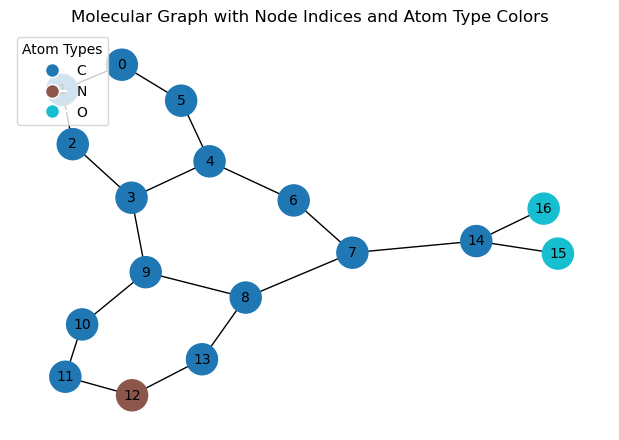

In [4]:
idx = 0
node_attr = dataset[idx].x.argmax(dim=-1)
node_attr = node_attr.numpy()
edge_list = dataset[idx].edge_index.T.tolist()
atomic_num_symbol_map_total = {0:'C',
 1:'N',
 2:'O',
 3:'F',
 4:'I',
 5:'Cl',
 6:'Br'}
unique_node_attr = np.unique(node_attr)
atomic_num_symbol_map = {k: atomic_num_symbol_map_total[k] for k in node_attr}
visualize_molecule_graph(edge_list, node_attr, atomic_num_symbol_map)

In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



In [32]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool


class GCN_pyg(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_pyg, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN_pyg(hidden_channels=64)
print(model)

GCN_pyg(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [33]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN_pyg(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
train_losses = []
test_aucs = []
def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)


def test(loader):
    model.eval()
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        correct = 0
        for data in loader:  # Iterate in batches over the testing dataset.
            out = model(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Store true labels and predicted probabilities for AUC calculation
            true_labels.extend(data.y.cpu().numpy())
            predicted_probs.extend(out.softmax(dim=1)[:, 1].cpu().numpy())  # Probability of the positive class

    # Calculate accuracy
    accuracy = correct / len(loader.dataset)

    # Calculate AUC if there are at least two classes
    if len(set(true_labels)) > 1:
        auc = roc_auc_score(true_labels, predicted_probs)
    else:
        auc = 0.5  # Assign AUC of 0.5 if only one class is present

    return accuracy, auc

for epoch in range(1, 101):
    train_loss = train()  # Train and get the training loss
    train_acc, _ = test(train_loader)  # Get training accuracy
    test_acc, test_auc = test(test_loader)  # Get test accuracy and AUC

    # Store the training loss and test AUC
    train_losses.append(train_loss)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6856, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8393
Epoch: 002, Train Loss: 0.6763, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8357
Epoch: 003, Train Loss: 0.6659, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8393
Epoch: 004, Train Loss: 0.6593, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8357
Epoch: 005, Train Loss: 0.6518, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8321
Epoch: 006, Train Loss: 0.6495, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 007, Train Loss: 0.6278, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8250
Epoch: 008, Train Loss: 0.6412, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 009, Train Loss: 0.6334, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 010, Train Loss: 0.6367, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 011, Train Loss: 0.6469, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8321
Epoch: 012, Train Loss: 0.6471, Train Acc: 0.6467, Tes

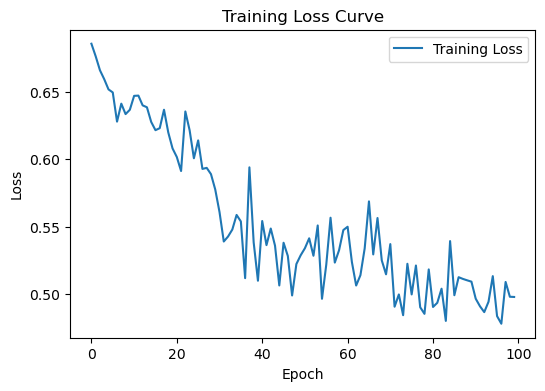

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

### Check with the self-defined model

In [37]:
from Model.layers import GCNLayer

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_channels, out_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_dim)
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [42]:
model = GCN(in_dim = dataset.num_node_features ,hidden_channels=64, out_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
train_losses = []
test_aucs = []
for epoch in range(1, 101):
    train_loss = train()  # Train and get the training loss
    train_acc, _ = test(train_loader)  # Get training accuracy
    test_acc, test_auc = test(test_loader)  # Get test accuracy and AUC

    # Store the training loss and test AUC
    train_losses.append(train_loss)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 001, Train Loss: 0.6861, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.5714
Epoch: 002, Train Loss: 0.6573, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.6536
Epoch: 003, Train Loss: 0.6612, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7143
Epoch: 004, Train Loss: 0.6543, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7536
Epoch: 005, Train Loss: 0.6311, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7714
Epoch: 006, Train Loss: 0.6533, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7821
Epoch: 007, Train Loss: 0.6332, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7821
Epoch: 008, Train Loss: 0.6103, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7893
Epoch: 009, Train Loss: 0.6267, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7750
Epoch: 010, Train Loss: 0.6337, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7750
Epoch: 011, Train Loss: 0.6512, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7821
Epoch: 012, Train Loss: 0.6204, Train Acc: 0.6467, Tes

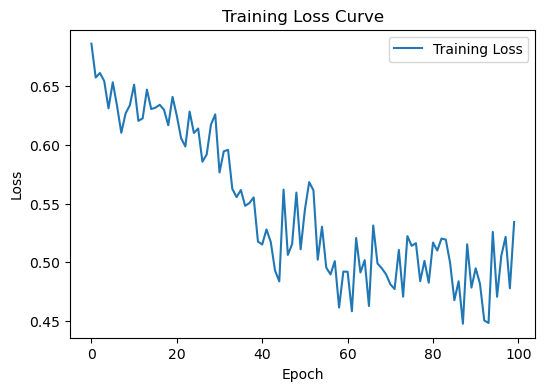

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()